In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_multilabel_classification
import scipy.linalg
from sklearn.cross_decomposition import CCA
import rcca
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import normalize

In [2]:
def qr_CCA(X,Y,n_components):
    #perform qr decomposition for X and Y
    q1,r1 = np.linalg.qr(X)
    q2,r2 = np.linalg.qr(Y)
    #perform SVD of q1 and q2
    U,s,Vh = np.linalg.svd(np.dot(q1.T,q2))
    
    a = np.dot(np.linalg.pinv(r1),U[:,:n_components])
    b = np.dot(np.linalg.pinv(r2),Vh.T[:,:n_components])
    #return U[:,:n_components],s[:n_components],Vh.T[:,:n_components]
    return a,s[:n_components],b

In [3]:
def prob_CCA(X,Y,n_components = 2):
    # we will create the sample covariance matrix
    z = np.concatenate((X.T,Y.T)) #combine the tranposed data.
    
    #Each row represents a variable and column represents sample
    # X & Y must have the same number of samples
    C = np.cov(z)
    
    sx = X.T.shape[0] #find the dimensions of X and Y
    sy = Y.T.shape[0]
    n = X.T.shape[1]
        
    #we partition the covariance matrix into the respective elements
    Cxx = C[0:sx,0:sx]
    Cxy = C[0:sx,sx:sx+sy]
    Cyx = Cxy.T
    Cyy = C[sx:,sx:]
    
    U1, Pd, U2 = qr_CCA(X,Y,n_components)
    
    M1 = np.diag(np.sqrt(Pd))
    M2 = M1
    
    W1 = np.dot(np.dot(Cxx,U1),M1)
    W2 = np.dot(np.dot(Cyy,U2),M2)
    
    Phi1 = Cxx - np.dot(W1,W1.T)
    Phi2 = Cyy - np.dot(W2,W2.T)
    
    mu1_mu = np.mean(X,axis = 0)
    mu2_mu = np.mean(Y,axis = 0)

    Mu1 = np.array([mu1_mu]*n)
    Mu2 = np.array([mu2_mu]*n)
    
    return W1,W2, Phi1,Phi2,Mu1,Mu2

In [4]:
def transform_to_z(X,Y,n_components=2,reg = 0):
    """
    cca = rcca.CCA(kernelcca = False,reg =reg, numCC = n_components)
    cca.train([X,Y])
    U1 = cca.ws[0]
    U2 = cca.ws[1]
    Pd = cca.cancorrs
    """
    U1, Pd, U2 = qr_CCA(X,Y,n_components)
    M1 = np.diag(np.sqrt(Pd))
    M2 = M1
    
    M_concat = np.concatenate((M1,M2),axis = 0)
    
    Pd_square = np.square(Pd)
    #print np.diag(Pd_square)
    I_Pd2_inv = np.linalg.inv(np.eye(n_components) - np.diag(Pd_square))
    I_Pd2_inv_Pd = np.dot(I_Pd2_inv,np.diag(Pd))
    
    left = np.concatenate((I_Pd2_inv,I_Pd2_inv_Pd),axis = 0)
    right = np.concatenate((I_Pd2_inv_Pd,I_Pd2_inv),axis = 0)
    
    middle = np.concatenate((left,right),axis = 1)
    
    mu1 = np.mean(X,axis = 0)
    mu2 = np.mean(Y,axis = 0)
    
    U1d = np.dot(U1.T,(X-mu1).T)
    U2d = np.dot(U2.T,(Y-mu2).T)
    
    U = np.concatenate((U1d,U2d),axis = 0)
    
    Ez = np.dot(np.dot(M_concat.T,middle),U)
    var_z = np.dot(np.dot(M_concat.T,middle),M_concat)
    #print np.eye(n_components) - np.diag(Pd_square)
    #print I_Pd2_inv
    #print Pd
    return Ez,var_z

In [5]:
def reduce_connectome(connectome):
    n_subjects = connectome.shape[0]
    group_ICA_dim = int(np.sqrt(connectome.shape[1]))
    reduced_connectome = np.zeros((n_subjects,group_ICA_dim*(group_ICA_dim-1)/2))
    upper_tri_indices = np.triu_indices(group_ICA_dim,k=1)
    for i in range(n_subjects):
        subject = np.reshape(connectome[i,:],(group_ICA_dim,group_ICA_dim))
        reduced_connectome[i,:] = subject[upper_tri_indices]
    return reduced_connectome

In [6]:
def get_treatment_nontreatment_groups(data):
    nontreatment = data[data['TreatmentGroup'] == 'Sham Exc+Sham cognitive']
    nontreatment_index = nontreatment.index.values
    
    treatment = data[data['TreatmentGroup'] != 'Sham Exc+Sham cognitive']
    treatment_index = treatment.index.values
    
    treatment_class = pd.get_dummies(data['TreatmentGroup'])
    
    return nontreatment_index, treatment_index, treatment_class

In [7]:
def get_neuro_scores(data):
    cog_headings = data.columns.values
    cog_headings = cog_headings[4:]
    neuro_scores = data[cog_headings]
    neuro_scores = neuro_scores.fillna(0)
    neuro_scores= neuro_scores.replace('.', 0, regex=True)
    return neuro_scores

In [8]:
def plot_study_result(X,Y):
    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    two_class = np.where(Y[:, 2])
    three_class = np.where(Y[:, 3])
    #plt.figure(figsize=((6,6)))
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray')
    one= plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                   facecolors='none', linewidths=2, label='Class C+R_Sham')
    two = plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                   facecolors='none', linewidths=2, label='Class R+C')
    three =plt.scatter(X[two_class, 0], X[two_class, 1], s=160, edgecolors='red',
                   facecolors='none', linewidths=2, label='Class R+C_Sham')
    four = plt.scatter(X[three_class, 0], X[three_class, 1], s=80, edgecolors='green',
                   facecolors='none', linewidths=2, label='Class Double Shammy')
    plt.legend(handles=[one,two,three,four])

In [9]:
def get_treatment_no(data):
    treatment_no = np.zeros((data.shape[0],1))
    i = 0
    for ele in data['TreatmentGroup'].unique():
        temp = data[data['TreatmentGroup'] == ele]
        temp_index = temp.index.values
        treatment_no[temp_index] = i
        i+=1

In [230]:
def compute_KL_divergence(mu1,mu2,sigma1,sigma2):
    """
    Computes the KL divergence between two multivariate gaussians
    i.e. KL(p(x)||q(x))
    """
    d = sigma1.shape[0]
    
    det_sigma1 = np.linalg.det(sigma1)
    det_sigma2 = np.linalg.det(sigma2)

    inv_sigma2 = np.linalg.inv(sigma2)

    diff_mu = mu2-mu1
    
    KL = 0.5*(np.log(det_sigma2/det_sigma1) -d + \
              np.trace(np.dot(inv_sigma2,sigma1))+\
             np.dot(np.dot(diff_mu.T,inv_sigma2),diff_mu))
    return KL

## BL analysis

In [10]:
BL_data = pd.read_excel('/home/hngu4068/Documents/SMART_STUDY/SMART_MasterDatabase_CCA.xlsx',sheetname = 1)

In [11]:
BL_data.head()

,TreatmentGroup,ParticipantStudyID,Ageyears,EducationYrs,TICSMScore_BL,TotalDrinksperweek_BL,TotalInformantBayerIADLscore_BL,ParticipantSubjectiveMemoryConcernTotalScore_BL,MMSETrial1UncorrectedScore_BL,MMSETrial1CorrectedScore_BL,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Sham Exc+Sham cognitive,2,70.59,19,21,0.000,1.160,2,28,30,...,2.195,2.565,1.961,2.491,2.238,2.276,3.588,1.884,2.836,2.27532
1,Resistance training+ Sham cognitive,3,65.62,19,27,7.000,1.231,5,27,27,...,2.297,2.570,1.981,2.609,2.259,2.496,3.097,2.132,2.634,2.31103
2,Cognitive training+Sham exc,4,78.96,14,16,0.000,1.217,3,29,30,...,2.085,2.456,2.070,2.472,2.180,2.216,3.462,2.499,2.650,2.22049
3,Resistance training + Cognitive training,6,65.70,14,24,7.000,1.269,3,28,28,...,2.335,2.689,2.170,2.645,2.461,2.818,3.097,2.495,2.748,2.39028
4,Resistance training+ Sham cognitive,7,70.92,20,24,0.000,2.680,4,27,27,...,2.438,2.594,2.305,2.688,2.458,2.484,3.384,2.452,2.743,2.48118


In [12]:
BL_treatment_no = get_treatment_no(BL_data)
BL_neuro_scores = get_neuro_scores(BL_data)
BL_neuro_scores['TotalDrinksperweek_BL'] = pd.to_numeric(BL_neuro_scores['TotalDrinksperweek_BL'])

In [13]:
BL_neuro_scores_scale = minmax_scale(BL_neuro_scores)

In [14]:
BL_connectome = np.loadtxt('NET_BL.txt')

In [15]:
reduced_BL_connectome = reduce_connectome(BL_connectome)
BL_connectome_normalize = normalize(reduced_BL_connectome)

In [16]:
BL_study_result = transform_to_z(BL_neuro_scores_scale,BL_connectome_normalize)

In [17]:
BL_study_latent = BL_study_result[0].T
BL_nontreatment_index, BL_treatment_index, BL_treatment_class = get_treatment_nontreatment_groups(BL_data)
BL_treatment_study_latent = BL_study_latent[BL_treatment_index,:]
BL_nontreatment_study_latent = BL_study_latent[BL_nontreatment_index,:]

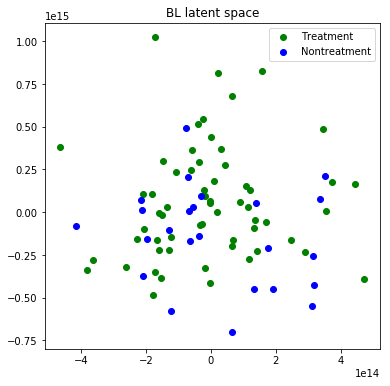

In [18]:
plt.figure(figsize=((6,6)))
one = plt.scatter(BL_treatment_study_latent[:,0],BL_treatment_study_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(BL_nontreatment_study_latent[:,0],BL_nontreatment_study_latent[:,1],color = 'blue',label='Nontreatment')
plt.legend(handles = [one,two])
plt.title('BL latent space')

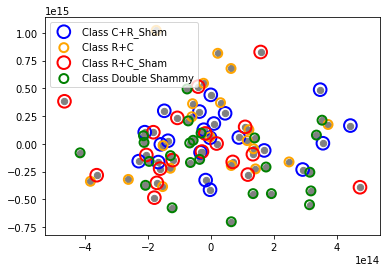

In [19]:
BL_treatment_class = pd.get_dummies(BL_data['TreatmentGroup'])
plot_study_result(BL_study_latent,BL_treatment_class.values)

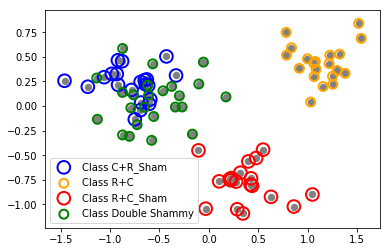

In [85]:
#lets see if we can distinguish between the classes
BL_study_alt_result = transform_to_z(BL_neuro_scores_scale,BL_connectome_normalize,n_components = 38)
BL_temp = transform_to_z(BL_study_alt_result[0].T,BL_treatment_class.values)
plot_study_result(BL_temp[0].T,BL_treatment_class.values)

### Lets do BL analysis by splitting into treatment and non treatment group

In [21]:
BL_treatment_neuro_scale = BL_neuro_scores_scale[BL_treatment_index,:]
BL_nontreatment_neuro_scale = BL_neuro_scores_scale[BL_nontreatment_index,:]

BL_connectome_treatment = BL_connectome_normalize[BL_treatment_index,:]
BL_connectome_nontreatment = BL_connectome_normalize[BL_nontreatment_index,:]

In [22]:
BL_treatment_result = prob_CCA(BL_treatment_neuro_scale,BL_connectome_treatment,2)
BL_nontreatment_result = prob_CCA(BL_nontreatment_neuro_scale,BL_connectome_nontreatment,2)

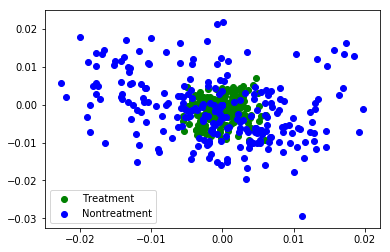

In [23]:
one = plt.scatter(BL_treatment_result[0][:,0],BL_treatment_result[0][:,1],color='green',label = 'Treatment')
two = plt.scatter(BL_nontreatment_result[0][:,0],BL_nontreatment_result[0][:,1],color='blue',label = 'Nontreatment')
plt.legend(handles = [one,two])

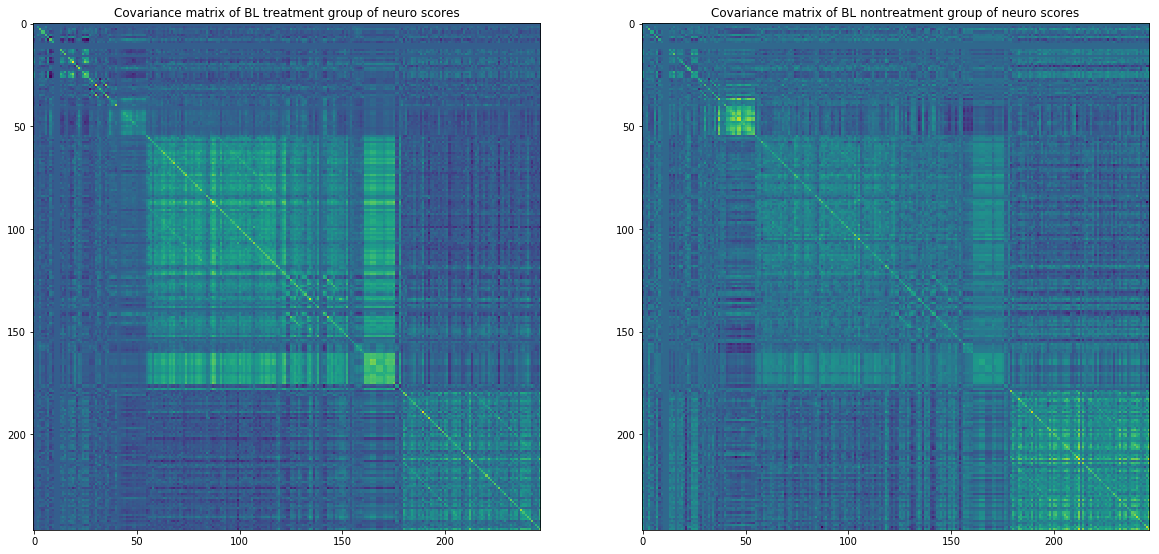

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(BL_treatment_result[2])
plt.title("Covariance matrix of BL treatment group of neuro scores")
plt.subplot(1,2,2)
plt.imshow(BL_nontreatment_result[2])
plt.title("Covariance matrix of BL nontreatment group of neuro scores")

In [25]:
#lets get the mean and variance of the weights for nontreatment and treatment group
print np.mean(BL_treatment_result[0],axis=0)
print np.mean(BL_nontreatment_result[0],axis=0)

print np.cov(BL_treatment_result[0].T)
print np.cov(BL_nontreatment_result[0].T)

[-0.00024874 -0.00120285]
[-0.00098029 -0.0012989 ]
[[  5.31470608e-06   8.86518024e-07]
 [  8.86518024e-07   9.54334355e-06]]
[[  8.29156539e-05  -2.33519240e-05]
 [ -2.33519240e-05   7.15034307e-05]]


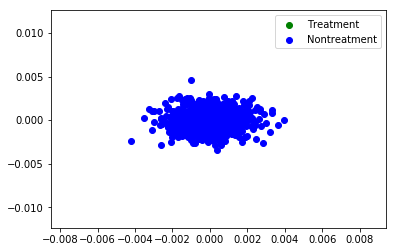

In [26]:
one = plt.scatter(BL_treatment_result[1][:,0],BL_treatment_result[1][:,1],color='green',label = 'Treatment')
two = plt.scatter(BL_nontreatment_result[1][:,0],BL_nontreatment_result[1][:,1],color='blue',label = 'Nontreatment')
plt.legend(handles = [one,two])

# FU1 analysis

In [27]:
FU1_data = pd.read_excel('/home/hngu4068/Documents/SMART_STUDY/SMART_MasterDatabase_CCA.xlsx',sheetname = 2)
FU1_data.head()

,TreatmentGroup,ParticipantStudyID,Ageyears,EducationYrs,TotalInformantBayerIADLscore_612,ParticipantSubjectiveMemoryConcernTotalScore_612,CDRSum_612,SUMofmemorytrials_612,ADASCOGTotalScore_612,MMSEUncorrectedScore_612,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Sham Exc+Sham cognitive,2,70.59,19,1.115,.,2.0,17.0,12.0,.,...,2.197,2.599,1.944,2.459,2.219,2.262,3.581,1.883,2.790,2.27350
1,Resistance training+ Sham cognitive,3,65.62,19,1.153,.,0.5,23.0,6.6,.,...,2.341,2.607,2.002,2.680,2.302,2.655,3.291,2.285,2.738,2.36391
2,Cognitive training+Sham exc,4,78.96,14,1.000,.,4.5,15.0,15.3,.,...,2.357,2.546,2.008,2.671,2.374,2.507,3.827,2.376,2.887,2.37256
3,Resistance training + Cognitive training,6,65.70,14,1.346,.,0.0,24.0,6.0,.,...,2.205,2.503,2.193,2.642,2.519,2.320,3.375,2.449,2.868,2.33653
4,Resistance training+ Sham cognitive,7,70.92,20,3.615,.,0.0,24.0,6.6,.,...,2.250,2.765,2.202,2.619,2.484,2.509,3.248,2.189,2.680,2.42852


In [28]:
FU1_treatment_no = get_treatment_no(FU1_data)
FU1_nontreatment_index,FU1_treatment_index, FU1_treatment_class = get_treatment_nontreatment_groups(FU1_data)
FU1_neuro_scores = get_neuro_scores(FU1_data)
FU1_neuro_scores_scale = minmax_scale(FU1_neuro_scores)

#get the treatment and non treatment groups
FU1_treatment_neuro_scale = FU1_neuro_scores_scale[FU1_treatment_index,:]
FU1_nontreatment_neuro_scale = FU1_neuro_scores_scale[FU1_nontreatment_index,:]

In [29]:
FU1_connectome = np.loadtxt('NET_FU1.txt')
FU1_connectome_reduced = reduce_connectome(FU1_connectome)
FU1_connectome_normalize = normalize(FU1_connectome_reduced)

FU1_connectome_treatment = FU1_connectome_normalize[FU1_treatment_index,:]
FU1_connectome_nontreatment = FU1_connectome_normalize[FU1_nontreatment_index,:]

In [30]:
FU1_study_result = transform_to_z(FU1_neuro_scores_scale,FU1_connectome_normalize)

FU1_study_latent = FU1_study_result[0].T
FU1_treatment_study_latent = FU1_study_latent[FU1_treatment_index,:]
FU1_nontreatment_study_latent = FU1_study_latent[FU1_nontreatment_index,:]

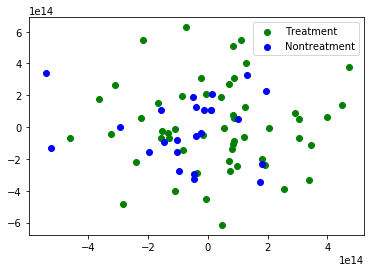

In [31]:
one = plt.scatter(FU1_treatment_study_latent[:,0],FU1_treatment_study_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(FU1_nontreatment_study_latent[:,0],FU1_nontreatment_study_latent[:,1],color = 'blue',label='Nontreatment')
plt.legend(handles=[one,two])

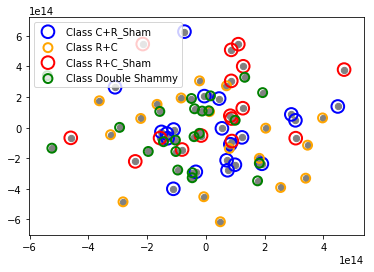

In [32]:
plot_study_result(FU1_study_result[0].T,FU1_treatment_class.values)

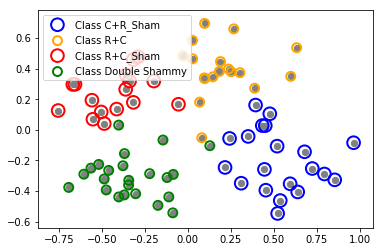

In [78]:
#lets see if we can distinguish between the classes
FU1_study_alt_result = transform_to_z(FU1_neuro_scores_scale,FU1_connectome_normalize,n_components = 25)
FU1_temp = transform_to_z(FU1_study_alt_result[0].T,FU1_treatment_class.values)
plot_study_result(FU1_temp[0].T,FU1_treatment_class.values)

In [34]:
# lets do CCA on the group split
FU1_treatment_result = prob_CCA(FU1_treatment_neuro_scale,FU1_connectome_treatment,2)
FU1_nontreatment_result = prob_CCA(FU1_nontreatment_neuro_scale,FU1_connectome_nontreatment,2)

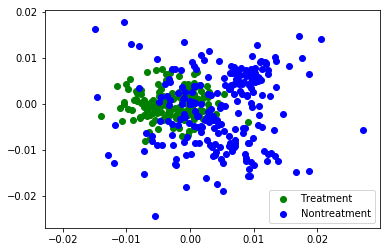

In [35]:
one = plt.scatter(FU1_treatment_result[0][:,0],FU1_treatment_result[0][:,1],color='green',label = 'Treatment')
two = plt.scatter(FU1_nontreatment_result[0][:,0],FU1_nontreatment_result[0][:,1],color='blue',label = 'Nontreatment')
plt.legend(handles = [one,two])

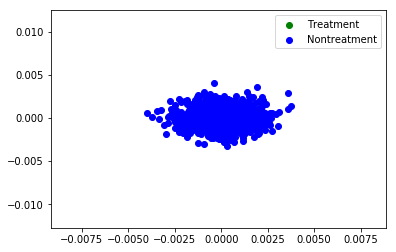

In [36]:
one = plt.scatter(FU1_treatment_result[1][:,0],FU1_treatment_result[1][:,1],color='green',label = 'Treatment')
two = plt.scatter(FU1_nontreatment_result[1][:,0],FU1_nontreatment_result[1][:,1],color='blue',label = 'Nontreatment')
plt.legend(handles = [one,two])

# Lets look at FU2

In [42]:
FU2_data = pd.read_excel('/home/hngu4068/Documents/SMART_STUDY/SMART_MasterDatabase_CCA.xlsx',sheetname = 3)
FU2_data.head()

,TreatmentGroup,ParticipantStudyID,Ageyears,EducationYrs,TotalInformantBayerIADLscore_1812,ParticipantSubjectiveMemoryConcernTotalScore_1812,CDRSum_1812,SUMofmemorytrials_1812,ADASCOGTotalScore_1812,MMSEUncorrectedScore_1812,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Sham Exc+Sham cognitive,2,70.59,19,1.125,0.0,0.0,22.0,3.6,.,...,2.157,2.555,1.939,2.482,2.189,2.298,3.659,1.821,2.780,2.24567
1,Resistance training+ Sham cognitive,3,65.62,19,1.115,2.0,0.0,26.0,4.9,.,...,2.296,2.581,1.998,2.626,2.282,2.541,3.216,2.176,2.720,2.33162
2,Cognitive training+Sham exc,4,78.96,14,1.291,3.0,2.5,16.0,9.6,24,...,1.957,2.324,1.812,2.475,1.998,1.993,3.584,2.401,2.695,2.10551
3,Resistance training + Cognitive training,6,65.70,14,1.269,2.0,0.0,27.0,4.0,30,...,2.269,2.665,2.150,2.669,2.425,2.863,3.089,2.642,2.731,2.35755
4,Resistance training+ Sham cognitive,7,70.92,20,1.692,2.0,1.0,24.0,5.6,28,...,2.261,2.477,2.043,2.587,2.176,2.265,3.278,2.139,2.646,2.29072


In [43]:
FU2_treatment_no = get_treatment_no(FU2_data)
FU2_nontreatment_index,FU2_treatment_index, FU2_treatment_class = get_treatment_nontreatment_groups(FU2_data)
FU2_neuro_scores = get_neuro_scores(FU2_data)
FU2_neuro_scores_scale = minmax_scale(FU2_neuro_scores)

#get the treatment and non treatment groups
FU2_treatment_neuro_scale = FU2_neuro_scores_scale[FU2_treatment_index,:]
FU2_nontreatment_neuro_scale = FU2_neuro_scores_scale[FU2_nontreatment_index,:]

In [46]:
FU2_connectome = np.loadtxt('NET_FU2.txt')
FU2_connectome = np.concatenate((FU2_connectome[1:35,:],FU2_connectome[36:,:]))
FU2_connectome_reduced = reduce_connectome(FU2_connectome)
FU2_connectome_normalize = normalize(FU2_connectome_reduced)

FU2_connectome_treatment = FU2_connectome_normalize[FU2_treatment_index,:]
FU2_connectome_nontreatment = FU2_connectome_normalize[FU2_nontreatment_index,:]

In [47]:
FU2_study_result = transform_to_z(FU2_neuro_scores_scale,FU2_connectome_normalize)

FU2_study_latent = FU2_study_result[0].T
FU2_treatment_study_latent = FU2_study_latent[FU2_treatment_index,:]
FU2_nontreatment_study_latent = FU2_study_latent[FU2_nontreatment_index,:]

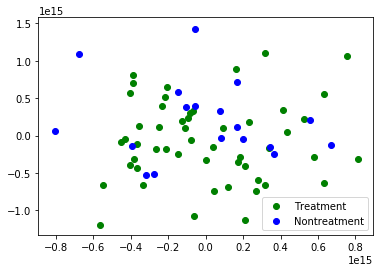

In [49]:
one = plt.scatter(FU2_treatment_study_latent[:,0],FU2_treatment_study_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(FU2_nontreatment_study_latent[:,0],FU2_nontreatment_study_latent[:,1],color = 'blue',label='Nontreatment')
plt.legend(handles=[one,two])

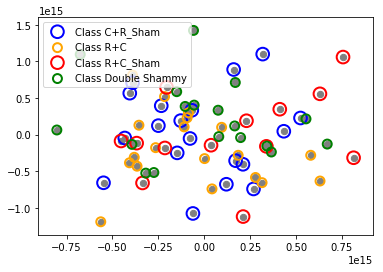

In [50]:
plot_study_result(FU2_study_result[0].T,FU2_treatment_class.values)

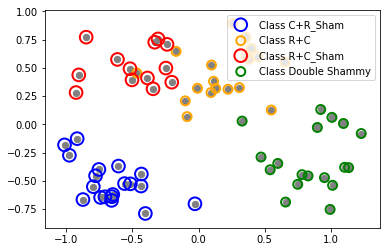

In [91]:
#lets see if we can distinguish between the classes
FU2_study_alt_result = transform_to_z(FU2_neuro_scores_scale,FU2_connectome_normalize,n_components = 30)
FU2_temp = transform_to_z(FU2_study_alt_result[0].T,FU2_treatment_class.values)
plot_study_result(FU2_temp[0].T,FU2_treatment_class.values)

In [52]:
# lets do CCA on the group split
FU2_treatment_result = prob_CCA(FU2_treatment_neuro_scale,FU2_connectome_treatment,2)
FU2_nontreatment_result = prob_CCA(FU2_nontreatment_neuro_scale,FU2_connectome_nontreatment,2)

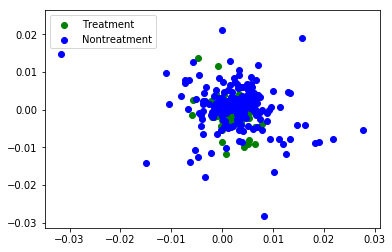

In [53]:
one = plt.scatter(FU2_treatment_result[0][:,0],FU2_treatment_result[0][:,1],color='green',label = 'Treatment')
two = plt.scatter(FU2_nontreatment_result[0][:,0],FU2_nontreatment_result[0][:,1],color='blue',label = 'Nontreatment')
plt.legend(handles = [one,two])

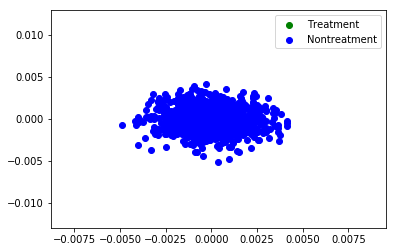

In [54]:
one = plt.scatter(FU2_treatment_result[1][:,0],FU2_treatment_result[1][:,1],color='green',label = 'Treatment')
two = plt.scatter(FU2_nontreatment_result[1][:,0],FU2_nontreatment_result[1][:,1],color='blue',label = 'Nontreatment')
plt.legend(handles = [one,two])

# Lets plot Bl,FU1 and FU2 side by side

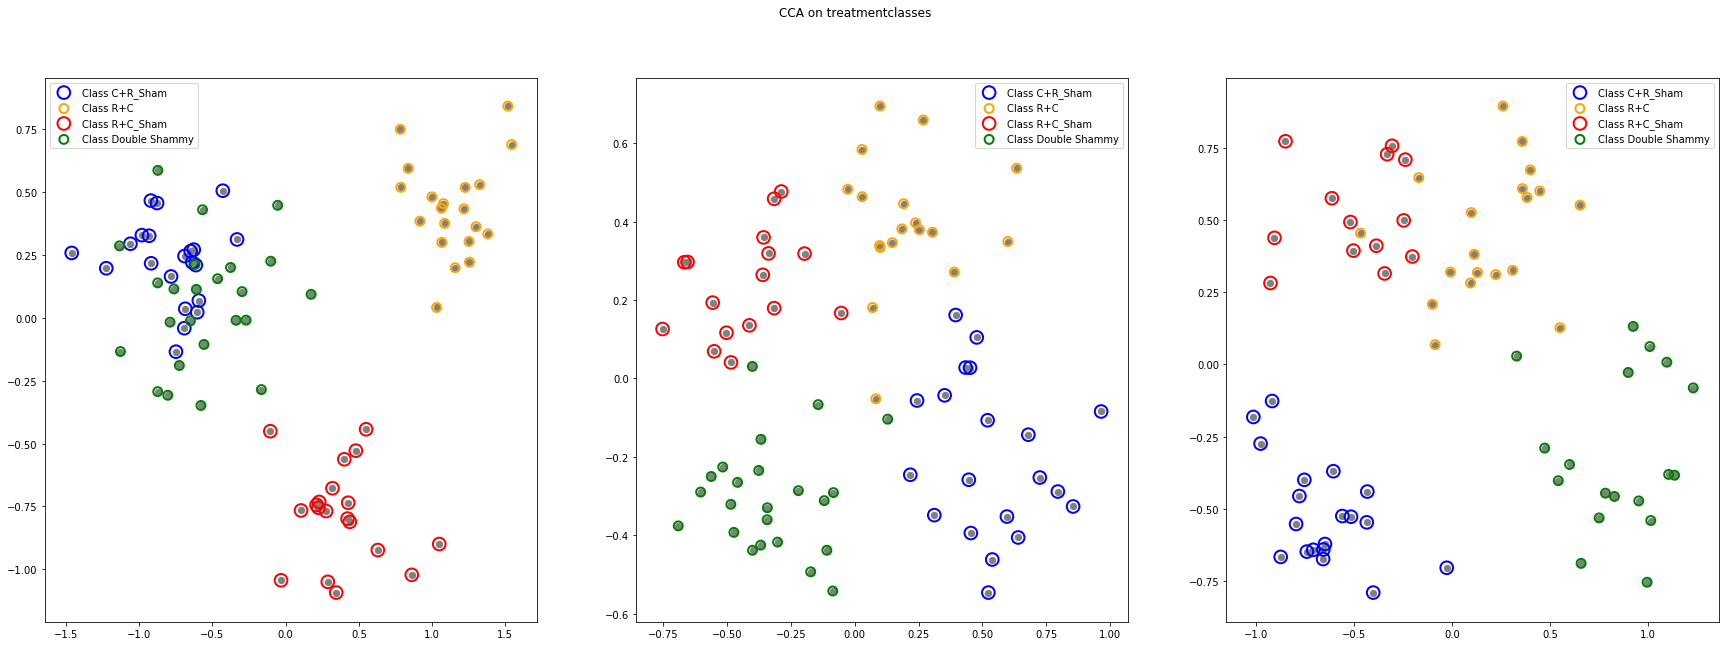

In [92]:
plt.figure(figsize=(30,10))
plt.suptitle("CCA on treatmentclasses")
plt.subplot(1,3,1)
plot_study_result(BL_temp[0].T,BL_treatment_class.values)
plt.subplot(1,3,2)
plot_study_result(FU1_temp[0].T,FU1_treatment_class.values)
plt.subplot(1,3,3)
plot_study_result(FU2_temp[0].T,FU2_treatment_class.values)

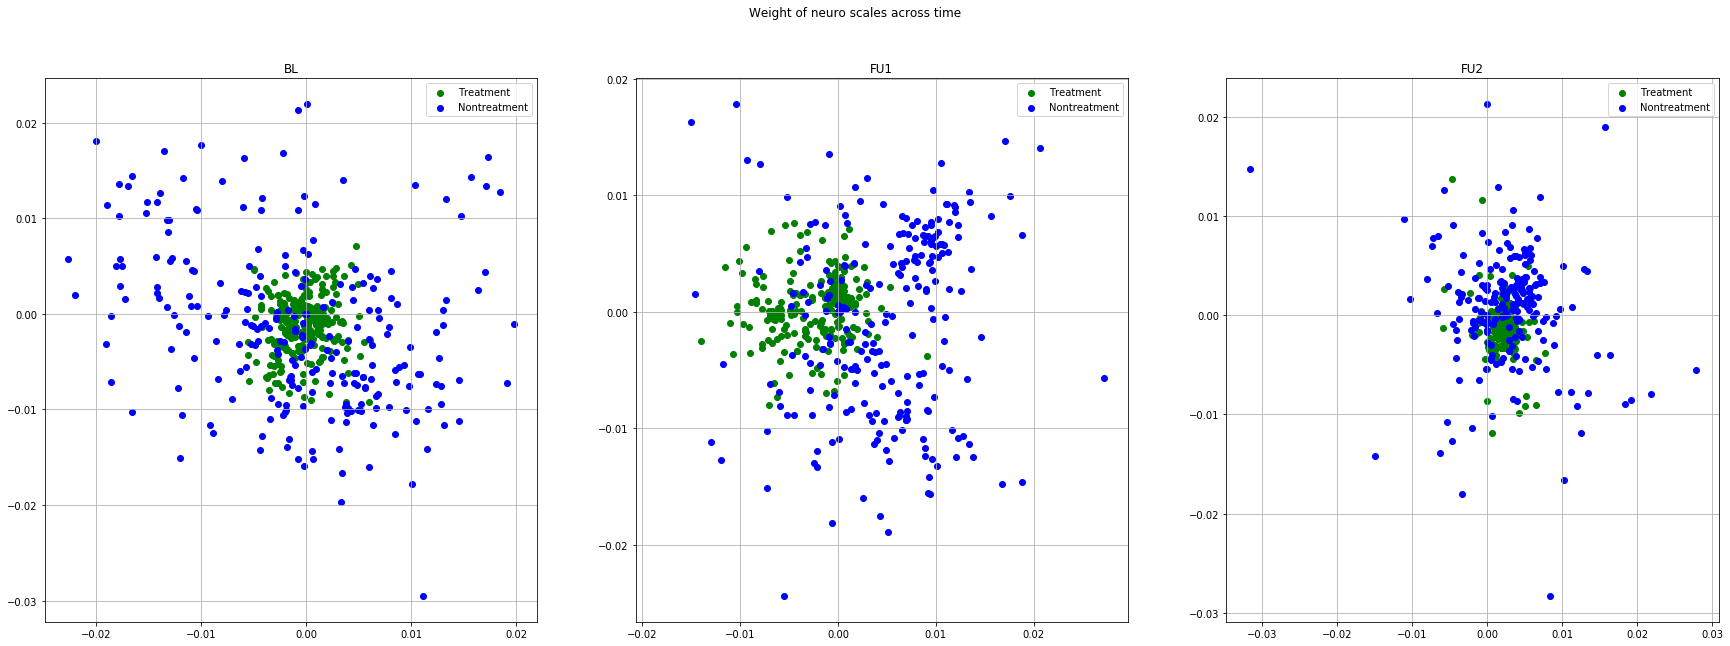

In [94]:
plt.figure(figsize=(30,10))
plt.suptitle("Weight of neuro scales across time")
plt.subplot(1,3,1)
one = plt.scatter(BL_treatment_result[0][:,0],BL_treatment_result[0][:,1],color='green',label = 'Treatment')
two = plt.scatter(BL_nontreatment_result[0][:,0],BL_nontreatment_result[0][:,1],color='blue',label = 'Nontreatment')
plt.title("BL")
plt.legend(handles = [one,two])
plt.grid()

plt.subplot(1,3,2)
one = plt.scatter(FU1_treatment_result[0][:,0],FU1_treatment_result[0][:,1],color='green',label = 'Treatment')
two = plt.scatter(FU1_nontreatment_result[0][:,0],FU1_nontreatment_result[0][:,1],color='blue',label = 'Nontreatment')
plt.title("FU1")
plt.legend(handles = [one,two])
plt.grid()

plt.subplot(1,3,3)
one = plt.scatter(FU2_treatment_result[0][:,0],FU2_treatment_result[0][:,1],color='green',label = 'Treatment')
two = plt.scatter(FU2_nontreatment_result[0][:,0],FU2_nontreatment_result[0][:,1],color='blue',label = 'Nontreatment')
plt.title("FU2")
plt.legend(handles = [one,two])
plt.grid()

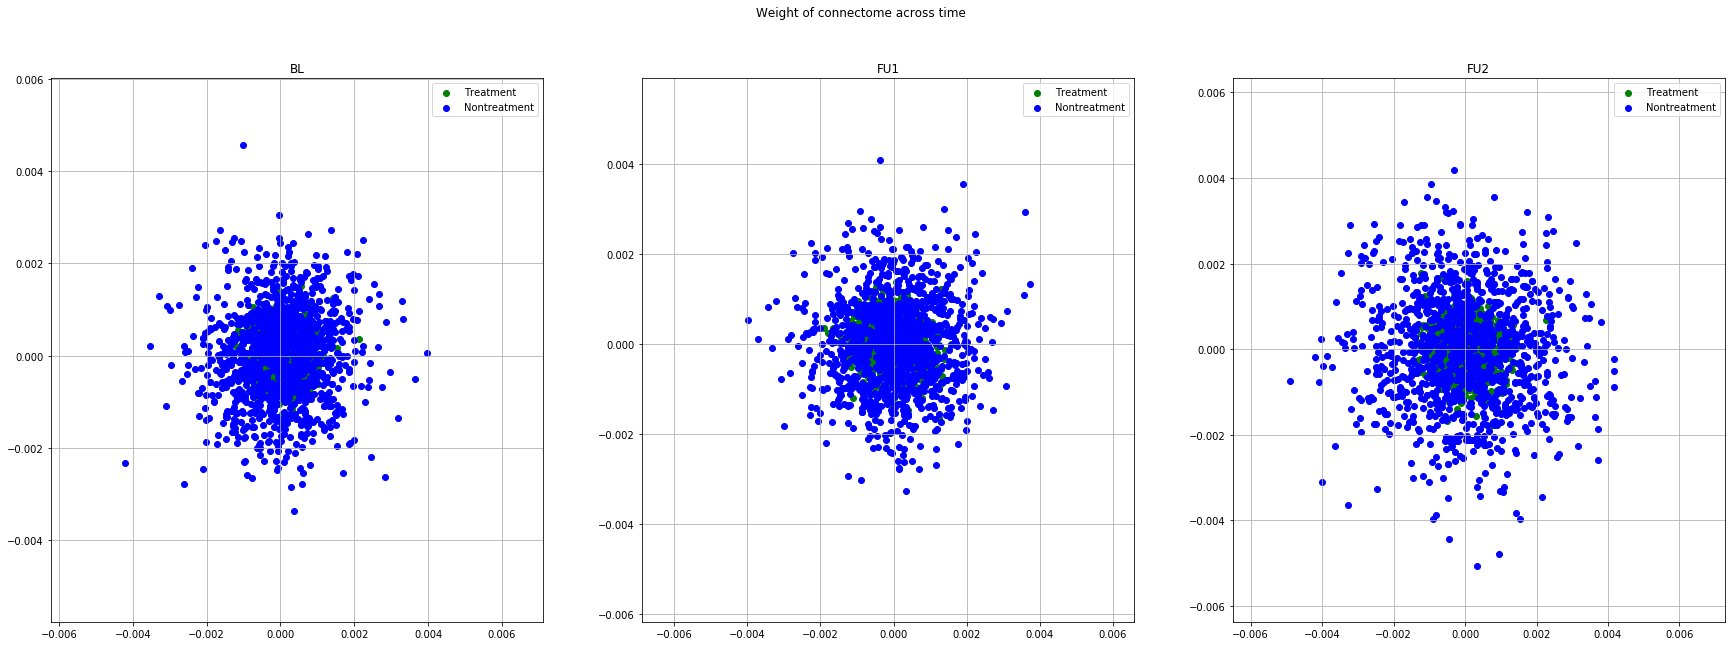

In [95]:
plt.figure(figsize=(30,10))
plt.suptitle("Weight of connectome across time")
plt.subplot(1,3,1)
one = plt.scatter(BL_treatment_result[1][:,0],BL_treatment_result[1][:,1],color='green',label = 'Treatment')
two = plt.scatter(BL_nontreatment_result[1][:,0],BL_nontreatment_result[1][:,1],color='blue',label = 'Nontreatment')
plt.title("BL")
plt.legend(handles = [one,two])
plt.grid()

plt.subplot(1,3,2)
one = plt.scatter(FU1_treatment_result[1][:,0],FU1_treatment_result[1][:,1],color='green',label = 'Treatment')
two = plt.scatter(FU1_nontreatment_result[1][:,0],FU1_nontreatment_result[1][:,1],color='blue',label = 'Nontreatment')
plt.title("FU1")
plt.legend(handles = [one,two])
plt.grid()

plt.subplot(1,3,3)
one = plt.scatter(FU2_treatment_result[1][:,0],FU2_treatment_result[1][:,1],color='green',label = 'Treatment')
two = plt.scatter(FU2_nontreatment_result[1][:,0],FU2_nontreatment_result[1][:,1],color='blue',label = 'Nontreatment')
plt.title("FU2")
plt.legend(handles = [one,two])
plt.grid()

### Lets compute KL divergences

In [231]:
#compute divergences of the neuroscores weights
#first compute the mean and covs of the weights at each time
BL_W1_mean =np.mean(BL_treatment_result[0],axis = 0)
BL_W1_cov =np.cov(BL_treatment_result[0].T)

FU1_W1_mean =np.mean(FU1_treatment_result[0],axis = 0)
FU1_W1_cov =np.cov(FU1_treatment_result[0].T)

FU2_W1_mean =np.mean(FU2_treatment_result[0],axis = 0)
FU2_W1_cov =np.cov(FU2_treatment_result[0].T)

#compute divergence BL||FU1
BL_FU1_W1_div = compute_KL_divergence(BL_W1_mean,FU1_W1_mean,BL_W1_cov,FU1_W1_cov)
BL_FU2_W1_div = compute_KL_divergence(BL_W1_mean,FU2_W1_mean,BL_W1_cov,FU2_W1_cov)
FU1_FU2_W1_div = compute_KL_divergence(FU1_W1_mean,FU2_W1_mean,FU1_W1_cov,FU2_W1_cov)

In [232]:
# Do the same for the connectome weights
BL_W2_mean =np.mean(BL_treatment_result[1],axis = 0)
BL_W2_cov =np.cov(BL_treatment_result[1].T)

FU1_W2_mean =np.mean(FU1_treatment_result[1],axis = 0)
FU1_W2_cov =np.cov(FU1_treatment_result[1].T)

FU2_W2_mean =np.mean(FU2_treatment_result[1],axis = 0)
FU2_W2_cov =np.cov(FU2_treatment_result[1].T)

#compute divergence BL||FU1
BL_FU1_W2_div = compute_KL_divergence(BL_W2_mean,FU1_W2_mean,BL_W2_cov,FU1_W2_cov)
BL_FU2_W2_div = compute_KL_divergence(BL_W2_mean,FU2_W2_mean,BL_W2_cov,FU2_W2_cov)
FU1_FU2_W2_div = compute_KL_divergence(FU1_W2_mean,FU2_W2_mean,FU1_W2_cov,FU2_W2_cov)

In [233]:
print BL_FU1_W1_div
print BL_FU2_W1_div
print FU1_FU2_W1_div

0.512012069795
1.29746957293
4.42782823421


In [234]:
print BL_FU1_W2_div
print BL_FU2_W2_div
print FU1_FU2_W2_div

0.0180043311563
0.05192374762
0.0171247812384
